In [491]:
using LinearAlgebra
using PyPlot
import TensorCrossInterpolation as TCI
using QuanticsTCI
using Cubature

include("honeycomb.jl")
include("kanemele.jl")
include("latticeplot.jl")
include("berry.jl")
include("chern.jl")

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["text.usetex"] = true

function displaymatrix(A::Matrix)
    show(stdout, "text/plain", A)
end

function maxlinkdim(n::Integer, localdim::Integer=2)
    return 0:n-2, [min(localdim^i, localdim^(n - i)) for i in 1:(n-1)]
end

maxlinkdim (generic function with 2 methods)

# Honeycomb lattice

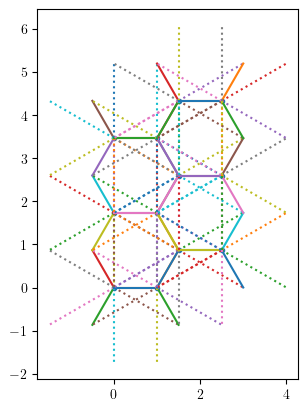

In [492]:
q = 3
B = 4pi / sqrt(3) / q

lattice = honeycomblattice(0, 1, 0, q - 1)

fig, ax = subplots()

sitesplot = collect(zip(realspacecoordinates.(lattice.fromint)...))
ax.plot(sitesplot..., ".")
ax.set_aspect(1)

for s in lattice.fromint
    for n in neighbours(s)
        ax.plot(collect(zip(realspacecoordinates.([s, n])...))...)
    end

    for n in nextneighbours(s)
        ax.plot(collect(zip(realspacecoordinates.([s, n])...))..., ":")
    end
end


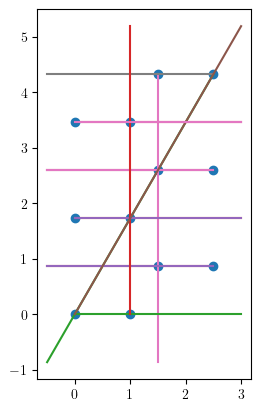

In [493]:
fig, ax = subplots()

sitesplot = collect(zip(realspacecoordinates.(lattice.fromint)...))
ax.plot(sitesplot..., "o")
ax.set_aspect(1)

for s in lattice.fromint
    for n in neighbours(s)
        norig = realspacecoordinates(n)
        nmap = realspacecoordinates(reducesite(n, 1, q))
        ax.plot([norig[1], nmap[1]], [norig[2], nmap[2]])
    end
end

# Hamiltonian

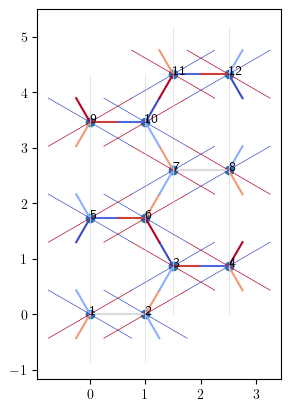

In [494]:
cm = get_cmap("coolwarm")

fig, ax = subplots()

sitesplot = collect(zip(realspacecoordinates.(lattice.fromint)...))
ax.plot(sitesplot..., "o")
ax.set_aspect(1)

for (i, rs) in enumerate(realspacecoordinates.(lattice.fromint))
    ax.annotate(i, xy=rs)
end

phimatrix = zeros(ComplexF64, 4q, 4q)
for (i, s) in enumerate(lattice.fromint)

    for n in neighbours(s)
        phi = peierls(B, s, n)
        rs, rn = realspacecoordinates.([s, n])
        midpoint = (rs + rn) / 2
        ax.plot([rs[1], midpoint[1]], [rs[2], midpoint[2]], color=cm(0.5 * imag(exp(1im * phi)) + 0.5))
    end

    for n in nextneighbours(s)
        phi = peierls(B, s, n)
        phiinv = peierls(B, n, s)

        rs, rn = realspacecoordinates.([s, n])
        midpoint = (rs + rn) / 2
        ax.plot([rs[1], midpoint[1]], [rs[2], midpoint[2]], linewidth=0.5, color=cm(0.5 * imag(exp(1im * phi)) + 0.5))
        phimatrix[i, TCI.pos(lattice, reducesite(n, 1, q))] += exp(1im * phi)
    end
end

In [495]:
Ht = get_Ht(q, [pi / 2, 3], lattice)
#displaymatrix(Ht[:, 1, :, 1])
print("\nHt is hermitian: $([Ht[:, a, :, b] ≈ adjoint(Ht[:, a, :, b]) for a in 1:2, b in 1:2])")


Ht is hermitian: Bool[1 1; 1 1]

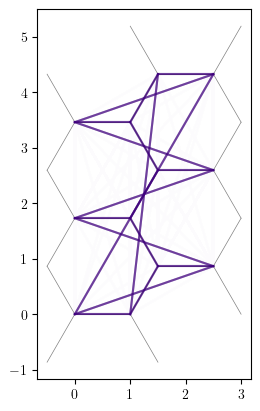

In [496]:
fig, ax = subplots()
displayhamiltonian(ax, abs.(Ht[:, 1, :, 1]), lattice)

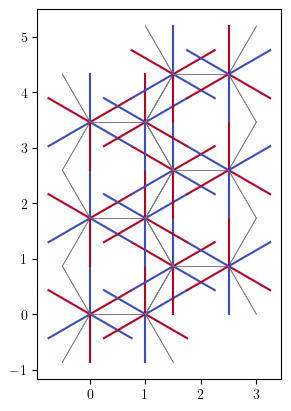

In [497]:
cm = get_cmap("coolwarm")

fig, ax = subplots()
ax.set_aspect(1)

for s in lattice.fromint
    for n in neighbours(s)
        for nn in neighbours(n)
            rs, rn, rnn = realspacecoordinates.([s, n, nn])
            ax.plot([rs[1], rn[1]], [rs[2], rn[2]], color="gray", linewidth=0.5)

            value = sign(antisymmetricproduct(rn - rs, rnn - rn))
            midpoint = (rs + rnn) / 2
            ax.plot([rs[1], midpoint[1]], [rs[2], midpoint[2]], color=cm((1 + value) / 2))
        end
    end
end


Hlambda is hermitian: Bool[1 1; 1 1]


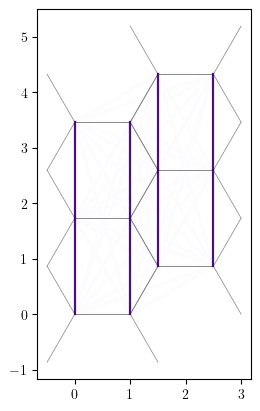

In [498]:
Hlambda = get_Hlambda(q, [0.0, 0.0], lattice)

fig, ax = subplots()
ax.set_aspect(1)
displayhamiltonian(ax, abs.(Hlambda[:, 1, :, 1]), lattice)

println("\nHlambda is hermitian: $([Hlambda[:, a, :, b] ≈ adjoint(Hlambda[:, a, :, b]) for a in 1:2, b in 1:2])")

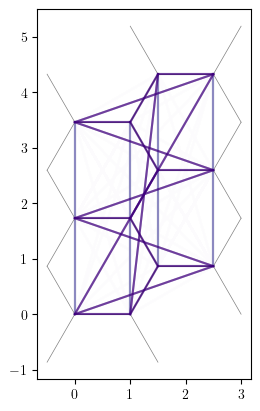

In [499]:
H = get_H(q, 0.6, [0.0, 0.0], lattice)

fig, ax = subplots()
ax.set_aspect(1)
displayhamiltonian(ax, abs.(H[:, 1, :, 1]), lattice)

# Band structure

/Users/Ritter.Marc/.pyenv/versions/3.8.15/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


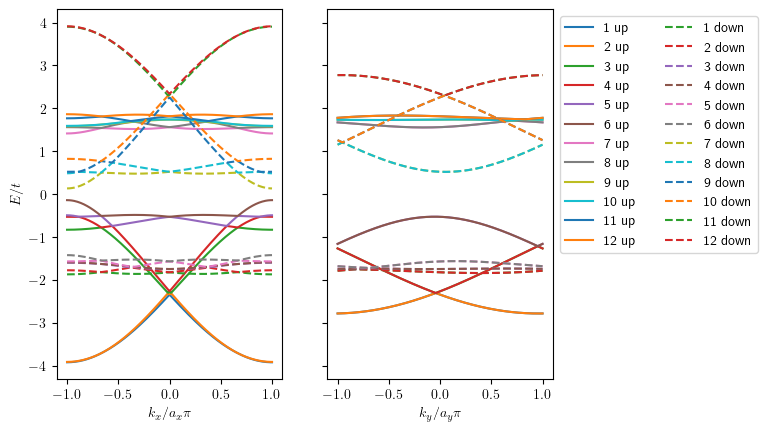

PyObject <matplotlib.legend.Legend object at 0x37681e460>

In [500]:
function bands(q, lambdaSO, kx, ky, mass)
    H = get_H(q, lambdaSO, [kx, ky], lattice; mass)
    return eigvals(H[:, 1, :, 1]), eigvals(H[:, 2, :, 2])
end

lambdaSO = 0.3 #/ (3 * sqrt(3))
mass = 0.3

nquantics = 8
ndiscretization = 2^nquantics

BZedgex = pi / 1.5 / 2
kxvals = range(-BZedgex, BZedgex; length=ndiscretization)
BZedgey = pi / sqrt(3) / q
kyvals = range(-BZedgey, BZedgey; length=ndiscretization)

fig, axs = subplots(ncols=2, sharey=true)

bandsx = bands.(q, lambdaSO, kxvals, 0, mass)

axs[1].plot(kxvals / BZedgex, [b[1] for b in bandsx], "-", label=["$i up" for i in eachindex(bandsx[1][1])])
axs[1].plot(kxvals / BZedgex, [b[2] for b in bandsx], "--", label=["$i down" for i in eachindex(bandsx[1][2])])

bandsy = bands.(q, lambdaSO, 0, kyvals, mass)
axs[2].plot(kyvals / BZedgey, [b[1] for b in bandsy], "-", label=["$i up" for i in eachindex(bandsy[1][1])])
axs[2].plot(kyvals / BZedgey, [b[2] for b in bandsy], "--", label=["$i down" for i in eachindex(bandsy[1][2])])


axs[1].set_xlabel(L"$k_x/a_x\pi$")
axs[2].set_xlabel(L"$k_y/a_y\pi$")
axs[1].set_ylabel(L"$E/t$")
axs[2].legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


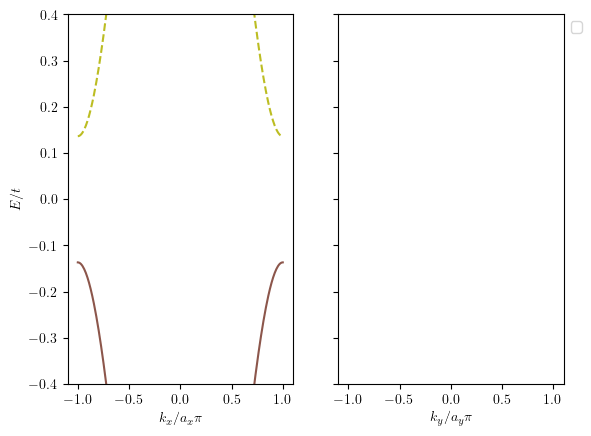

PyObject <matplotlib.legend.Legend object at 0x377949790>

In [501]:
fig, axs = subplots(ncols=2, sharey=true)

bandsx = bands.(q, lambdaSO, kxvals, 0, mass)
axs[1].plot(kxvals / BZedgex, [b[1] for b in bandsx], "-")
axs[1].plot(kxvals / BZedgex, [b[2] for b in bandsx], "--")

bandsy = bands.(q, lambdaSO, 0, kyvals, mass)
axs[2].plot(kyvals / BZedgey, [b[1] for b in bandsy], "-")
axs[2].plot(kyvals / BZedgey, [b[2] for b in bandsy], "--")

axs[1].set_xlabel(L"$k_x/a_x\pi$")
axs[2].set_xlabel(L"$k_y/a_y\pi$")
axs[1].set_ylabel(L"$E/t$")
axs[1].set_ylim(-0.4, 0.4)
axs[2].set_ylim(-0.4, 0.4)
axs[2].legend(loc="upper left", bbox_to_anchor=(1, 1))

# Eigenstates

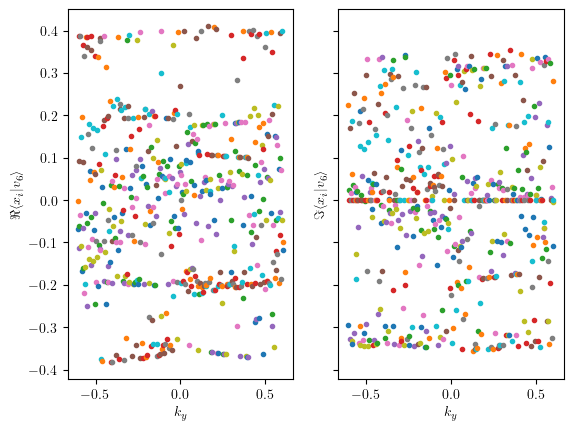

PyObject Text(327.68637510188574, 0.5, '$\\Im\\langle x_i | v_{6} \\rangle$')

In [508]:
function getstate(H, n=1:8q)
    values, vectors = eigen(H[:, 1, :, 1])
    ev = values[n]
    indices = filter(i -> any(values[i] .≈ ev), eachindex(values))
    return vectors[indices]
end

n = 6
states = [getstate(get_H(q, lambdaSO, [0, ky], lattice; mass), [n])[:] for ky in kyvals]

fig, axs = subplots(ncols=2, sharey=true)
for (ky, a) in zip(kyvals, states)
    axs[1].plot([ky], [real.(a)], ".")
    axs[2].plot([ky], [imag.(a)], ".")
end

axs[1].set_xlabel(L"$k_y$")
axs[1].set_ylabel("\$\\Re\\langle x_i | v_{$n} \\rangle\$")
axs[2].set_xlabel(L"$k_y$")
axs[2].set_ylabel("\$\\Im\\langle x_i | v_{$n} \\rangle\$")

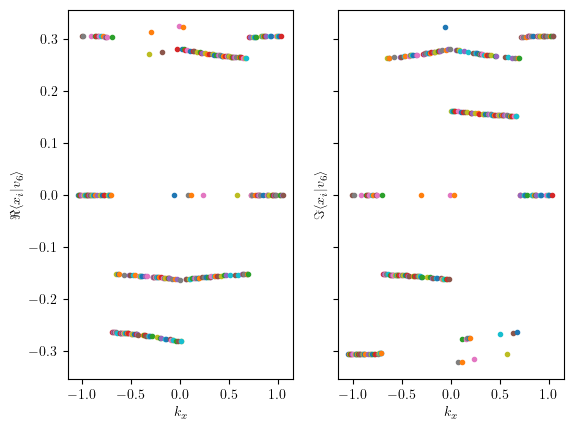

PyObject Text(327.68637510188574, 0.5, '$\\Im\\langle x_i | v_{6} \\rangle$')

In [509]:
states = [getstate(get_H(q, lambdaSO, [kx, 0], lattice; mass), [n])[:] for kx in kxvals]

fig, axs = subplots(ncols=2, sharey=true)
for (kx, a) in zip(kxvals, states)
    axs[1].plot([kx], [real.(a)], ".")
    axs[2].plot([kx], [imag.(a)], ".")
end

axs[1].set_xlabel(L"$k_x$")
axs[1].set_ylabel("\$\\Re\\langle x_i | v_{$n} \\rangle\$")
axs[2].set_xlabel(L"$k_x$")
axs[2].set_ylabel("\$\\Im\\langle x_i | v_{$n} \\rangle\$")

# Berry curvature

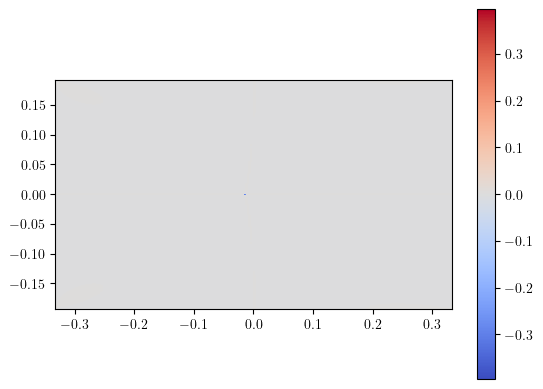

PyObject <matplotlib.colorbar.Colorbar object at 0x37a580790>

In [510]:
ϵ = [BZedgex, BZedgey] ./ ndiscretization

Hcached = TCI.CachedFunction{Matrix{ComplexF64}}(
    kindex -> get_H(q, lambdaSO, [kxvals[kindex[1]], kyvals[kindex[2]]] .+ ϵ, lattice; mass)[:, 1, :, 1],
    [ndiscretization, ndiscretization]
)

H = [Hcached([kxi, kyi]) for kxi in 1:ndiscretization, kyi in 1:ndiscretization]
A = berrycurvature_dets(H, n)
maxval = maximum(abs.(A))
imshow(A, cmap="coolwarm", extent=([-BZedgex, BZedgex, -BZedgey, BZedgey] ./ pi), vmin=-maxval, vmax=maxval) |> colorbar

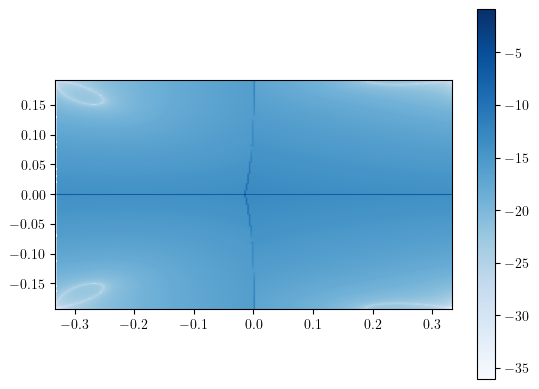

PyObject <matplotlib.colorbar.Colorbar object at 0x37a754fd0>

In [511]:
fig, ax = subplots()
ax.imshow(log.(abs.(A)), cmap="Blues", extent=([-BZedgex, BZedgex, -BZedgey, BZedgey] ./ pi)) |> colorbar

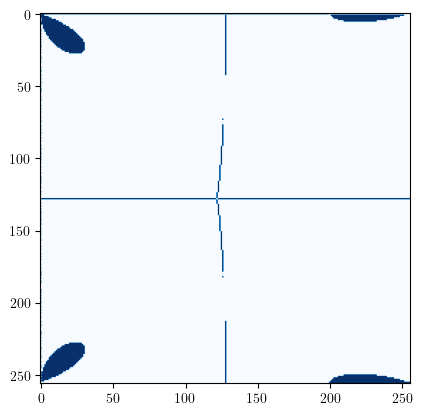

PyObject <matplotlib.image.AxesImage object at 0x37a8021f0>

In [512]:
imshow(sign.(A), cmap="Blues")

## Chern number through conventional sum

In [513]:
sum(A) / 2pi

-3.1805546814635168e-15

## Band structure in 2d

Compare Berry curvature

In [489]:
band2d = [real(bands(q, lambdaSO, kx, ky, mass)[1][n]) for kx in kxvals, ky in kyvals]

256×256 Matrix{Float64}:
 -2.24427  -2.2444   -2.24453  -2.24466  …  -2.24453  -2.2444   -2.24427
 -2.24443  -2.24457  -2.24471  -2.24485     -2.24471  -2.24457  -2.24443
 -2.24443  -2.24457  -2.24471  -2.24487     -2.24471  -2.24457  -2.24443
 -2.24425  -2.2444   -2.24455  -2.24472     -2.24455  -2.2444   -2.24425
 -2.2439   -2.24405  -2.24422  -2.2444      -2.24422  -2.24405  -2.2439
 -2.24339  -2.24354  -2.24371  -2.24391  …  -2.24371  -2.24354  -2.24339
 -2.2427   -2.24286  -2.24304  -2.24324     -2.24304  -2.24286  -2.2427
 -2.24184  -2.242    -2.24219  -2.24241     -2.24219  -2.242    -2.24184
 -2.24081  -2.24098  -2.24117  -2.24141     -2.24117  -2.24098  -2.24081
 -2.23961  -2.23978  -2.23999  -2.24023     -2.23999  -2.23978  -2.23961
 -2.23824  -2.23842  -2.23863  -2.23889  …  -2.23863  -2.23842  -2.23824
 -2.2367   -2.23689  -2.23711  -2.23738     -2.23711  -2.23689  -2.2367
 -2.235    -2.23518  -2.23541  -2.23569     -2.23541  -2.23518  -2.235
  ⋮                            

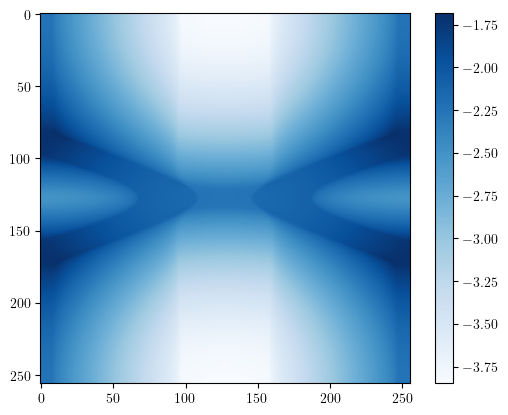

PyObject <matplotlib.colorbar.Colorbar object at 0x376829d00>

In [490]:
imshow(band2d, cmap="Blues") |> colorbar

# Quantics TCI rep of Berry curvature

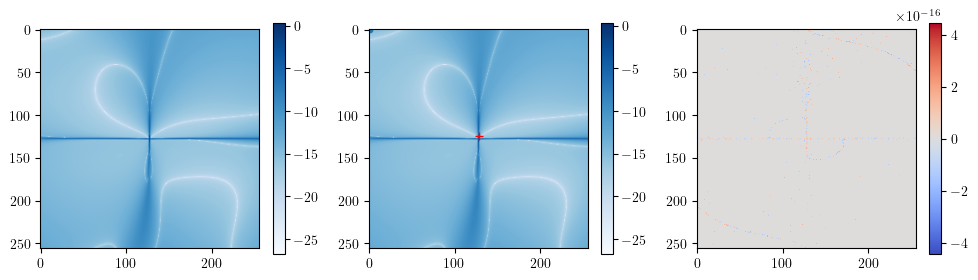

PyObject <matplotlib.colorbar.Colorbar object at 0x303856700>

In [77]:
f(q) = berrycurvature_quantics_dets(Hcached, n, q, nquantics)

firstpivot = TCI.optfirstpivot(f, fill(2, 2*nquantics))

fig, axs = subplots(ncols=3, figsize=(12, 3))
axs[1].imshow(log.(abs.(A)), cmap="Blues") |> colorbar

quanticsdata = [
    f(interleave_dimensions(index_to_quantics(kxi, nquantics), index_to_quantics(kyi, nquantics)))
    for kxi in 1:ndiscretization, kyi in 1:ndiscretization
]

axs[2].imshow(log.(abs.(quanticsdata)), cmap="Blues") |> colorbar
axs[2].plot(quantics_to_index(firstpivot[1:2:end]), quantics_to_index(firstpivot[2:2:end]), ".")
axs[2].plot(Tuple(argmax(log.(abs.(A))))..., "r+")

axs[3].imshow(quanticsdata .- A, cmap="coolwarm") |> colorbar

In [78]:
function crossinterpolate_chern(
    ::Type{ValueType},
    f,
    localdims::Vector{Int},
    firstpivot::MultiIndex=ones(Int, length(localdims));
    tolerance::Float64=1e-8,
    maxiter::Int=200,
    sweepstrategy::SweepStrategies.SweepStrategy=SweepStrategies.back_and_forth,
    pivottolerance::Float64=1e-12,
    errornormalization::Union{Nothing,Float64}=nothing,
    verbosity::Int=0
) where {ValueType}
    tci = TensorCI{ValueType}(f, localdims, firstpivot)
    n = length(tci)
    errors = Float64[]
    ranks = Int[]
    N::Float64 = isnothing(errornormalization) ? abs(f(firstpivot)) : abs(errornormalization)

    # Start at two, because the constructor already added a pivot everywhere.
    for iter in 2:maxiter
        foward_sweep = (
            sweepstrategy == SweepStrategies.forward ||
            (sweepstrategy != SweepStrategies.backward && isodd(iter))
        )

        if foward_sweep
            addpivot!.(tci, 1:n-1, f, pivottolerance)
        else
            addpivot!.(tci, (n-1):-1:1, f, pivottolerance)
        end

        push!(errors, lastsweeppivoterror(tci) / N)
        push!(ranks, maximum(rank(tci)))
        if verbosity > 0 && mod(iter, 10) == 0
            println("rank= $(last(ranks)) , error= $(last(errors))")
        end
        if last(errors) < tolerance
            break
        end
    end

    return tci, ranks, errors
end

tci, ranks, errors = TCI.crossinterpolate(
    Float64,
    f,
    fill(2, 2*nquantics),
    firstpivot,
    tolerance=1e-6,
    maxiter=200,
)

(TensorCrossInterpolation.TensorCI{Float64} with ranks 56, [2, 3, 4, 5, 6, 7, 8, 9, 10, 11  …  47, 48, 49, 50, 51, 52, 53, 54, 55, 56], [2.2076874143045995, 0.805220334516629, 1.1659907613146145, 36.033571104116994, 0.18015634854203247, 0.05676740416846314, 0.07267235291422627, 0.3084680524035187, 0.6417568283222906, 50.219678560369324  …  7.185963882778493e-6, 6.496472242719515e-6, 4.123990725655326e-6, 3.0557673037150632e-6, 1.7794389906465642e-6, 1.8180605386036086e-6, 1.7998981415251041e-6, 1.3680414972613022e-6, 1.326605093755183e-6, 9.673678769437364e-7])

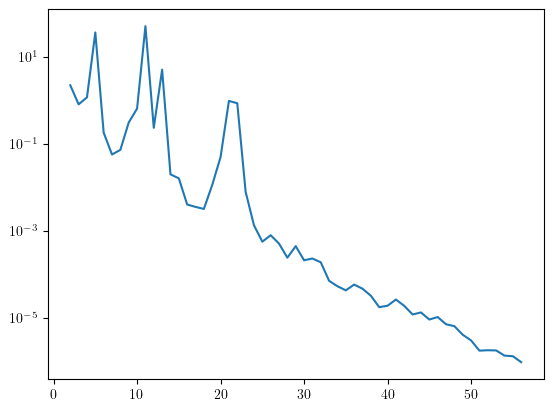

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x30395eb80>

In [79]:

semilogy(ranks, errors)

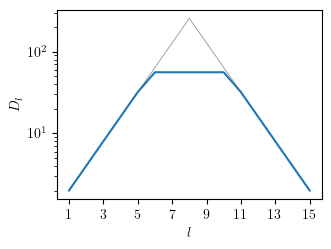

8-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.axis.XTick object at 0x3039af1c0>
 PyObject <matplotlib.axis.XTick object at 0x3039af190>
 PyObject <matplotlib.axis.XTick object at 0x30397bb20>
 PyObject <matplotlib.axis.XTick object at 0x3039deb80>
 PyObject <matplotlib.axis.XTick object at 0x3039dec40>
 PyObject <matplotlib.axis.XTick object at 0x3039e8e80>
 PyObject <matplotlib.axis.XTick object at 0x3039ee6a0>
 PyObject <matplotlib.axis.XTick object at 0x3039e87c0>

In [80]:
fig, ax = subplots(figsize=[246/72, 246/100])
ax.semilogy(1:2nquantics-1, maxlinkdim(2nquantics, 2)[2], color="gray", linewidth=0.5)
ax.semilogy(1:2nquantics-1, TCI.linkdims(tci))
ax.set_ylabel(L"$D_l$")
ax.set_xlabel(L"$l$")
ax.set_xticks(1:2:2nquantics-1)

In [81]:
function scalar(a::Matrix)
    if size(a) == (1, 1)
        return first(a)
    else
        throw(ArgumentError("$a is not a scalar."))
    end
end

function evaluate_qtt(qtt, q::Vector{<:Integer})
    return scalar(prod(T[:, i, :] for (T, i) in zip(qtt, q)))
end

qtt = TCI.tensortrain(tci)
qttdata = [
    evaluate_qtt(qtt, interleave_dimensions(index_to_quantics(kxi, nquantics), index_to_quantics(kyi, nquantics)))
    for kxi in eachindex(kxvals), kyi in eachindex(kyvals)
]

256×256 Matrix{Float64}:
 -0.376903    -0.0098      -0.00967428  …  -0.00762934  -0.00787809
  0.00327005   2.12992e-7   2.08296e-7      3.12756e-6   3.14902e-6
  0.00321902   1.88125e-7   1.83568e-7      2.98014e-6   3.00198e-6
  0.00316868   1.64472e-7   1.60063e-7      2.89596e-6   2.93463e-6
  0.00311903   1.42011e-7   1.37757e-7      2.83111e-6   2.86409e-6
  0.00307006   1.20715e-7   1.1662e-7   …   2.77623e-6   2.79677e-6
  0.00302176   1.00556e-7   9.6626e-8       2.70128e-6   2.71932e-6
  0.00297415   8.15052e-8   7.77422e-8      2.62276e-6   2.64e-6
  0.0029272    6.35293e-8   5.99363e-8      2.54263e-6   2.56252e-6
  0.00288092   4.65952e-8   4.31715e-8      2.46299e-6   2.49008e-6
  0.0028353    3.06687e-8   2.7415e-8   …   2.38629e-6   2.41808e-6
  0.00279033   1.57147e-8   1.26304e-8      2.30337e-6   2.3667e-6
  0.00274601   1.69728e-9  -1.2184e-9       2.24322e-6   2.29975e-6
  ⋮                                     ⋱                ⋮
  0.00111124  -2.10837e-6  -2.06101e

vmin = max(min(minimum.([plottransform2.(A), plottransform2.(qttdata)])...), -12) = -11.764153472490928
vmax = max(0, maximum.([plottransform2.(A), plottransform2.(qttdata)])...) = 0.13208856323099255


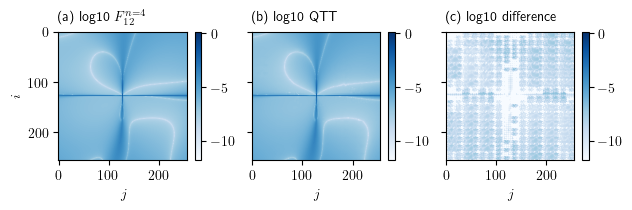

In [104]:
plottransform2(x) = log10(abs(x))
cmap = "Blues"

@show vmin = max(
    min(minimum.([plottransform2.(A), plottransform2.(qttdata)])...),
    -12)
@show vmax = max(0, maximum.([plottransform2.(A), plottransform2.(qttdata)])...)


fig, axs = subplots(ncols=3, figsize=(510/72, 120/72), sharey=true)
axs[1].imshow(plottransform2.(A), cmap=cmap, vmin=vmin, vmax=vmax) |> colorbar
axs[2].imshow(plottransform2.(qttdata), cmap=cmap, vmin=vmin, vmax=vmax) |> colorbar
axs[3].imshow(plottransform2.(qttdata .- A), cmap=cmap, vmin=vmin, vmax=vmax) |> colorbar

labels = [
    "(a) log10 \$F_{12}^{n=$n}\$",
    "(b) log10 QTT",
    "(c) log10 difference",
]

for (ax, label) in zip(axs, labels)
    ax.annotate(
        label,
        xy=(0, 1),
        xycoords="axes fraction",
        xytext=(0, 8),
        textcoords="offset points"
    )
end

axs[1].set_ylabel(L"$i$")
for ax in axs
    ax.set_xlabel(L"$j$")
end

In [97]:
function sumqtt(qtt)
    return prod(sum(T, dims=2)[:, 1, :] for T in qtt)[1]
end

sumqtt(qtt) / 2pi, sum(qttdata) / 2pi, sum(A) / 2pi

(0.9999884092002759, 0.9999884182247909, 0.9999999999999918)

Comment: Chern number is calculated to an accuracy comparable to the TCI precision.

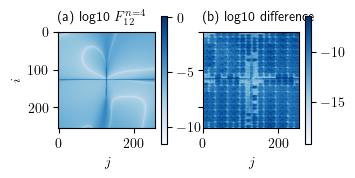

In [98]:
fig, axs = subplots(ncols=2, figsize=(246/72, 120/72), sharey=true)
axs[1].imshow(plottransform2.(A), cmap=cmap) |> colorbar
axs[2].imshow(plottransform2.(qttdata .- A), cmap=cmap) |> colorbar

labels = [
    "(a) log10 \$F_{12}^{n=$n}\$",
    "(b) log10 difference",
]

for (ax, label) in zip(axs, labels)
    ax.annotate(
        label,
        xy=(0, 1),
        xycoords="axes fraction",
        xytext=(0, 8),
        textcoords="offset points"
    )
end

axs[1].set_ylabel(L"$i$")
for ax in axs
    ax.set_xlabel(L"$j$")
end

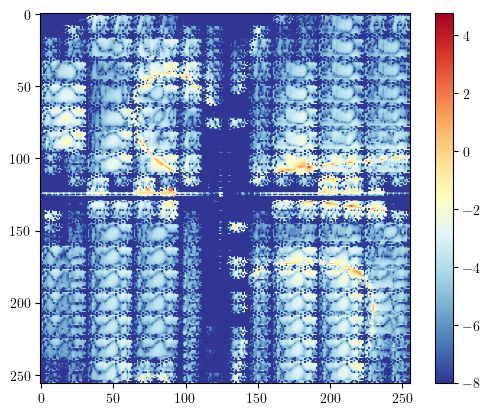

PyObject <matplotlib.colorbar.Colorbar object at 0x3049e89d0>

In [108]:
imshow(log.(abs.((qttdata .- A) ./ (qttdata .+ A) .* 2)), vmin=-8, cmap="RdYlBu_r") |> colorbar

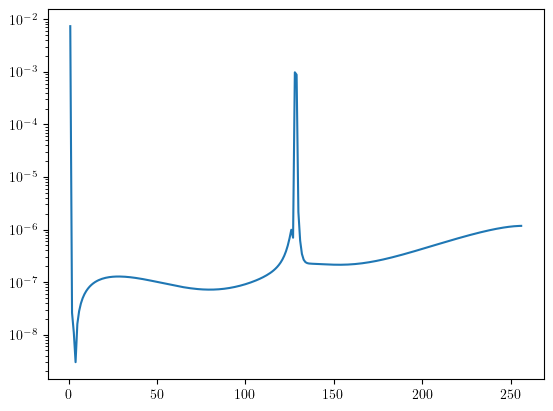

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x304d4dcd0>

In [101]:
semilogy(1:2^nquantics, abs.(A[:, 33]))

# Berry curvature with derivative method

In [146]:
# nquantics = 10
# ndiscretization = 2^nquantics

# BZedgex = pi / 1.5 / 2
# kxvals = range(-BZedgex, BZedgex; length=ndiscretization)
# BZedgey = pi / sqrt(3) / q
# kyvals = range(-BZedgey, BZedgey; length=ndiscretization)

Hfunc = (k -> get_H(q, lambdaSO, k, lattice)[:, 1, :, 1])
Hfuncderiv = ((k, derivdir) -> get_H(q, lambdaSO, k, lattice, derivative_direction=derivdir)[:, 1, :, 1])

berry_derivs = [
    berrycurvature_derivatives(Hfunc([kx, ky]), Hfuncderiv([kx, ky], 1), Hfuncderiv([kx, ky], 2), n)
    for kx in kxvals, ky in kyvals];

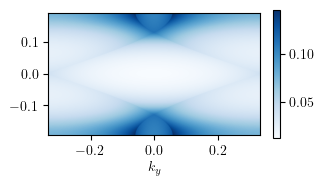

PyObject Text(0.5, 23.567907476682493, '$k_y$')

In [147]:
fig, ax = subplots(figsize=(246/72, 120/72))
ax.imshow(berry_derivs, cmap="Blues", extent=([-BZedgex, BZedgex, -BZedgey, BZedgey] ./ pi)) |> colorbar
ax.set_xlabel(L"$k_x$")
ax.set_xlabel(L"$k_y$")

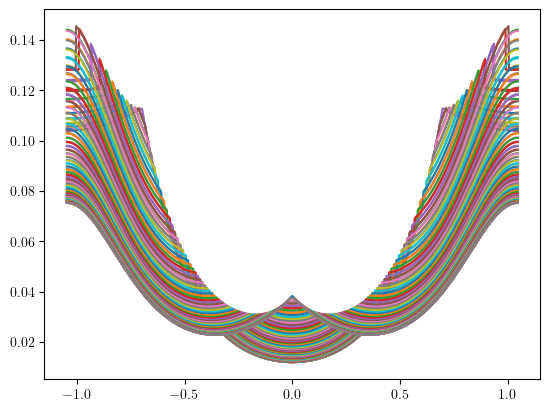

In [148]:
plot(kxvals, berry_derivs[:, 1:8:end]);

In [155]:
ndiscretization = 2^nquantics
bulkinds = 2:ndiscretization-1
cornerinds = [1, ndiscretization]
dk = 4 * BZedgex * BZedgey / ndiscretization^2 / 2pi^2
trapez = sum(berry_derivs[bulkinds, bulkinds]) +
    0.5 * (sum(berry_derivs[cornerinds, bulkinds]) + sum(berry_derivs[bulkinds, cornerinds])) +
    0.25 * (sum(berry_derivs[cornerinds, cornerinds]))
riemann = sum(berry_derivs)
trapez * dk, riemann * dk

(0.00619743873326349, 0.0062145819907244385)

In [156]:
(val, err) = hcubature(
    k ->
    berrycurvature_derivatives(Hfunc(k), Hfuncderiv(k, 1), Hfuncderiv(k, 2), 8),
    [-BZedgex, -BZedgey], [BZedgex, BZedgey]
)

val / (2pi)^2

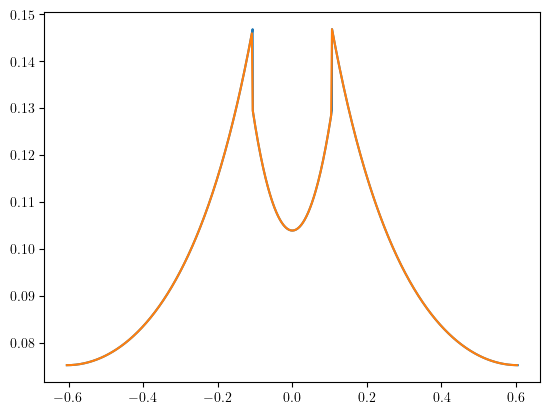

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2c42520d0>

In [141]:
kyplot = range(-BZedgey, BZedgey, length=4096)
berrycut = [
    berrycurvature_derivatives(Hfunc([BZedgex, ky]), Hfuncderiv([BZedgex, ky], 1), Hfuncderiv([BZedgex, ky], 2), n)
    for ky in kyplot]
plot(kyplot, berrycut)
plot(kyplot[1:8:end], berrycut[1:8:end])